In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
from csv import writer 
import math
from scipy.interpolate import interp1d
import numpy as np
import os

from scipy import optimize
import corner
import radvel
import radvel.likelihood
from radvel.plot import orbit_plots, mcmc_plots

In [125]:
#planet class that inherits the values from the target class
#reads in data file about the planet information 
class Planet(): 
    def __init__(self, PlanetID, Period, Eccentricity, Mplanet): 
        
        self.PlanetID = PlanetID
        self.Mplanet = Mplanet
        self.Eccentricity = Eccentricity
        self.Period = Period
        
    #defining what the name of the class is when an object created is called   
    def __repr__(self):
        return 'Planet Class'

In [146]:
#Target class loads in system data, gets attributes for multiple planets, and gets data about previous rv data
class Target(): 
    #needs a file for the target info and optional previous RV data
    def __init__(self, file, prev_rv_data = None): 
        #inherits planet class and creates empty array so that planet info will be stored
        self.Planets = []
        
        self.file = file
        
        #opens the file and reads it in 
        target_file = pd.read_csv(self.file, header = 0)
        ID = target_file['ID'][0]
        Mstar = target_file['Mstar'][0]
        
        self.ID = ID
        self.Mstar = Mstar
        self.prev_rv_data = None
            
        #if user has previous RV data
        if prev_rv_data != None:
            #reads in previous rv data and assigns them variables
            #these will be used to create plots
            
            file_prev_rv = pd.read_csv(prev_rv_data, header = 0)
            self.prev_rv_data = file_prev_rv

            prev_rv_time = file_prev_rv['time'] 
            prev_rv_bjd = file_prev_rv['bjd']
            prev_rv_errvel = file_prev_rv['errvel']
            prev_rv_mnvel = file_prev_rv['mnvel']

            self. prev_rv_time = prev_rv_time
            self.prev_rv_bjd = prev_rv_bjd
            self.prev_rv_errvel = prev_rv_errvel
            self.prev_rv_mnvel = prev_rv_mnvel
            
    #defining what the name of the class is when an object created is called               
    def __repr__(self):
        return 'Target Class:'#, self.Target.ID

    #creating a function that creates multiple objects of the planet class to create multiple planets
    #this will be read in by the csv file provided into the planet class
    def load_planets(self, planet_file):

        #reading in the planet file and assigning it variable data 
        data_pl = pd.read_csv(planet_file, header = 0)
        
        no_pl = len(data_pl)

        for i in range(no_pl):
            #subset of file will be the ith row that is iterated 
            subset = data_pl.iloc[i]
            
            #getting the values from the file for each planet in the system 
            planetID = subset['PlanetID']
            mplanet = subset['MPlanet']
            eccentricity = subset['Eccentricity']
            period = subset['Period']

            #creating individual objects for each planet and adding them to the list as defined in __init__
            planet = Planet(planetID, period, eccentricity, mplanet)
            self.Planets.append(planet)

In [127]:
#square root of G
G_sqrt = 28.4329

#mass of Jupiter in grams
M_J = 1.899 * 10**30

#mass of Sun in grams 
M_sun = 1.989*10**33

#year in seconds
yr = 3.154*10**7 

In [207]:
#creates the plots and the simulated data points
class RV_obs(Target): 
    def __init__(self, Target): 
        self.Target = Target
    
    
    #generates the times that the user will be observing over
    #user must enter in the time they are planning on starting to observe and the date they want to end 
    #they also have to add the number of observations to establish the cadence 
    #for now we are assuming an equal cadence rather than a random one 
    def Generate_times(self, t_obs, t_end, No_obs): 
        times = np.linspace(t_obs, t_end, No_obs)
        self.times = times
        return self.times
    
    #K value is the semi amplitude of the sin curve that will be generated from the RV data
    def K_value(self, times, planet, star): 
        #takes from the planet class to calculate the K value
        K = G_sqrt / (np.sqrt(1 - planet.Eccentricity**2)) * planet.Mplanet / M_J * \
        (star.Mstar / M_sun)**(-2/3) * (planet.Period / yr)**(-1/3)
        self.K = K
        return self.K 
    
    #creates the RV values that will be put into the RV plot
    def sim_RVs(self, t_obs, t_end, No_obs, t_ref, noise = 0): 
        times = self.Generate_times(t_obs, t_end, No_obs)
        Star = self.Target
        RVs = []
        RV_values = 0
        #this is to make sure that we get multiple RV data points for multiple planets for more than one planet
        #loops through the number of planets and goes into the Planet class to get the data 
        for planet in Star.Planets: 
            K = self.K_value(times, planet, Star)
            
            #takes from the planet class and the K_value class to calculate the RV data point
            RV_pl = -K*np.sin(2*np.pi*(times - t_ref)/planet.Period) + noise*np.random.randn(len(times))
            #adds RVs for every planet together 
            RV_values += RV_pl
            #all RVs is the final RV
            self.RV_values = RV_values
        return self.RV_values
    
    #plots the RV data created from the previous function
    def RV_plot(self, mode = 'sim'): 
        #simulated data is plotted
        if mode == 'sim': 
            fig = plt.figure()
            plt.scatter(self.times, self.RV_values)
            plt.xlabel('Time (JD)')
            plt.ylabel('RV')
            plt.title("Simulated Data")
            plt.show()
            self.fig = fig
            return self.fig
        #previous data loaded in from Target class is plotted
        elif mode == 'prev': 
            fig = plt.figure()
            plt.scatter(prev_rv_time.self, self.prev_rv_mnvel)
            plt.xlabel('Time (JD)')
            plt.ylabel('RV')
            plt.title("Previous RV Data")
            plt.show()
            self.fig = fig
            return self.fig
        #both simulated data and previous data are plotted
        elif mode == 'both': 
            fig = plt.figure()
            plt.scatter(prev_rv_time.self, self.prev_rv_mnvel, label = 'previous RV')
            plt.scatter(self.times, self.RV_values, label = 'simulated')
            plt.scatter()
            plt.xlabel('Time (JD)')
            plt.ylabel('RV')
            plt.legend()
            plt.show()
            self.fig = fig
            return self.fig
        plt.show()


In [ ]:
class radvel_fit(RV_obs):
    def __init__(self, RV_obs): 
        super().__init__(self, RV_obs)
    
    def __repr(self):
        return 'radvel fit class'
    
    def parameters(): 
        #need a parameter for each planet so I am looping through how many planets there are and then 
        #adding those values to the parameter values 
        #defining the basis for the parameter values 
        params = radvel.Parameters(2,basis='per tc e w k')
        for i in range(len(no_pl)): 
            time_base = (times.min() + times.max())/2
            params[f'per{i}'] = radvel.Parameter(value = planet[i].Period)
            params[f'tc{i}'] = radvel.Parameter(value = )
            params[f'e{i}'] = radvel.Parameter(value = 0.8)
            params[f'w{i}'] = radvel.Parameter(value = 0.02)
            params[f'k{i}'] = radvel.Parameter(value = planet[i].RV_obs.K_value)
            
            mod = radvel.RVModel(params, time_base=time_base)
            mod.params['dvdt'] = radvel.Parameter(value= -0.02)
            mod.params['curv'] = radvel.Parameter(value= 0.01)
            
        '''
        the rest of the code below is from the intro to astro github tutorial 
        ''' 
        mod = initialize_model() # initialize radvel.RVModel object
        like = radvel.likelihood.RVLikelihood(mod, data.t, data.vel, data.errvel, '_HIRES')
        like.params['gamma_HIRES'] = radvel.Parameter(value=0.1)
        like.params['jit_HIRES'] = radvel.Parameter(value=1.0)
        like.params['secosw1'].vary = False # set as false because we are assuming circular orbit
        like.params['sesinw1'].vary = False 
        like.params['secosw2'].vary = False # set as false because we are assuming circular orbit
        like.params['sesinw2'].vary = False 
        
        post = radvel.posterior.Posterior(like) # initialize radvel.Posterior object

        res  = optimize.minimize(
            post.neglogprob_array,     # objective function is negative log likelihood
            post.get_vary_params(),    # initial variable parameters
            method='Powell',           # Nelder-Mead also works
            )
        

In [208]:
system = Target(file = 'target_ex_file.csv')
planets = system.load_planets(planet_file = 'planet_ex_file.csv - Sheet1.csv')
system_RV_obs = RV_obs(system)
system.Planets[0].Period
system_RV_obs.sim_RVs(1, 50000, 15, 25000)

array([ 2.69503817e-05,  1.08417675e-05,  4.27229811e-06,  9.76857607e-06,
        2.04850691e-05,  2.54095272e-05,  1.77103325e-05, -6.07443484e-08,
       -1.78291159e-05, -2.55214245e-05, -2.05886777e-05, -9.86477323e-06,
       -4.36210033e-06, -1.09241870e-05, -2.70219203e-05])

In [209]:
system_RV_obs.RV_plot

<bound method RV_obs.RV_plot of Target Class:>

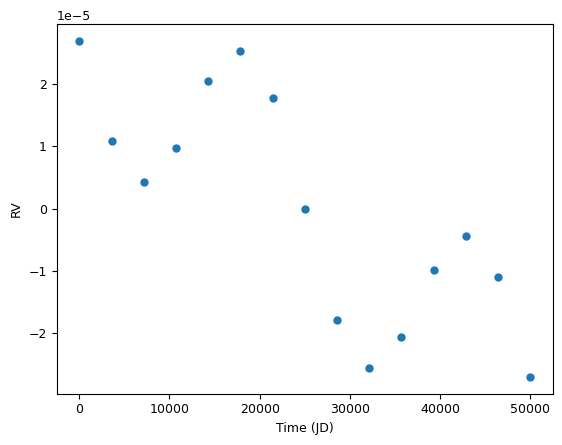

In [210]:
plt.figure()
plt.scatter(system_RV_obs.times, system_RV_obs.RV_values)
plt.xlabel('Time (JD)')
plt.ylabel('RV')
plt.show()